This notebook introduces the use of the morphodynamical trajectory embedding method on a live-cell imaging dataset of MCF10A cells responding to EGF over 48 hours (30 minutes between frames), see Morphodynamical cell-state description via live-cell imaging trajectory embedding
Jeremy Copperman, Sean M. Gross, Young Hwan Chang, Laura M. Heiser, Daniel M. Zuckerman, bioRxiv (2021) doi: https://doi.org/10.1101/2021.10.07.463498
For celltraj code installation and python environment requirements, see installation instructions https://jcopperm.github.io/celltraj/installation.html

In [1]:
%%capture
import matplotlib.pyplot as plt
import numpy as np
import sys, os, time, math
sys.path.append('/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj')
import jcTrajectory_CP as cellTraj

In [2]:
# live-cell imaging data file with images, cell masks (labels), and foreground masks
fileSpecifier = '/home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/scTrajAnl/LI204601_P_A2_1.h5'
modelName = 'mcf10a_EGF' # data label for outputs
sctm = cellTraj.Trajectory() # single-cell trajectory model (sctm) object
sctm.initialize(fileSpecifier, modelName)

In [3]:
%%capture
sctm.get_frames() # get number of frames
start_frame = 0
end_frame = sctm.maxFrame
sctm.get_imageSet(start_frame, end_frame); # pull images, cell masks, and foreground/background masks into the sctm object for further analysis

These are unlabeled phase contrast images of MCF10A mammary epithelial cells in 2D culture in EGF containing media. Lets see what these images look like

In [4]:
# Function to Z-normalize images
def z_normalize(image):
    return (image - np.nanmean(image))/np.nanstd(image)

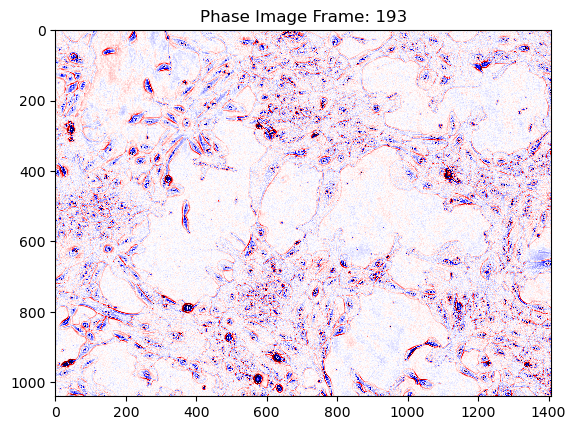

In [5]:
from IPython.display import clear_output
plt.clf()
for i in range(end_frame + 1):
    clear_output(wait = True)
    sctm.imgSet[i, :, :] = z_normalize(sctm.imgSet[i, :, :]) # Z-normalize phase images 
    plt.imshow(sctm.imgSet[i, :, :], cmap = plt.cm.seismic, clim = (-3, 3))
    plt.title('Phase Image Frame: {}'.format(i+1))
    plt.pause(.2)

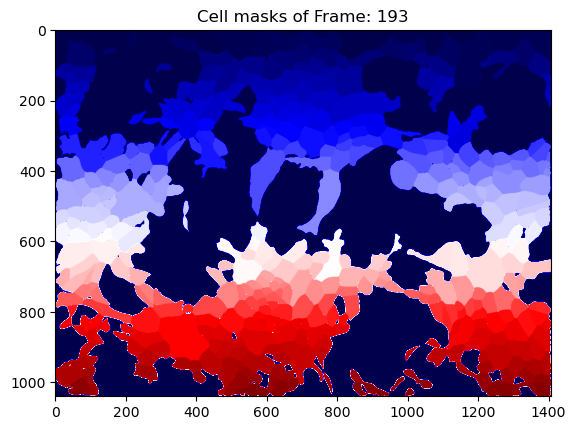

In [30]:
plt.clf()
plt.figure(figsize = (8, 4))
for i in range(end_frame + 1):
    clear_output(wait = True)
    plt.imshow(sctm.mskSet[i, :, :], cmap = plt.cm.seismic) # Cell masks' visualization
    plt.title('Cell masks of Frame: {}'.format(i+1))
    plt.pause(.2)

Cell segmentation was performed in cellpose (cellpose.org). For the the cells that were segmented in the image set, we extract the single-cell features.

In [6]:
%%capture
sctm.get_imageSet_trans_turboreg() # Register images
sctm.get_cell_data()  # Gather single-cell label information
sctm.get_cell_images() # Extract single-cell images
sctm.get_cellborder_images() # Extract cellborder images
sctm.prepare_cell_images() # Prepare single-cell images
sctm.prepare_cell_features(apply_znorm = False) # Extract single-cell Zernike moments, texture...

We now track cells (linking cells between frames) by first aligning each connected cell cluster and then linking cells by segmentation overlap. In this label-free imaging setting, segmentation and tracking errors are abundant, but the morphodynamical trajectory embedding method can still leverage trajectory information to improve single-cell characterization, see https://doi.org/10.1101/2021.10.07.463498.

In [7]:
%%capture
sctm.visual = False
# Using the Bayesian Tracking tool (https://btrack.readthedocs.io/en/latest/) to track single-cell trajectories
sctm.get_lineage_btrack() 

Instantiating BTRACK interface wrapper (v0.4.2, compiled Jul 13 2021 at 11:23:01)
GLPK Integer Optimizer 5.0
1108 rows, 1000 columns, 1485 non-zeros
1000 integer variables, all of which are binary
Preprocessing...
554 rows, 1000 columns, 1485 non-zeros
1000 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 554
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
554 rows, 1000 columns, 1485 non-zeros
*     0: obj =   6.735808606e+02 inf =   0.000e+00 (232)
*   183: obj =   1.895010064e+02 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+   183: mip =     not found yet >=              -inf        (1; 0)
+   183: >>>>>   1.895010064e+02 >=   1.895010064e+02   0.0% (1; 0)
+   183: mip =   1.895010064e+02 >=     tree is empty   0.0% (0; 1)
INTEGER OPTIMAL SOLUTI

We can examine the morphological feature space by looking at a PCA decomposition. Coloring these PCAs by individual features (here the fraction of the cell boundary making cell-cell contact) provides insight into the heterogeneity of the cell morphology.

In [8]:
def plot_pca(self, nd=12, colors=None):
        if self.visual:
            if colors is None:
                colors = 'black'
            plt.figure(figsize = (10, 8))
            nplots = 1 + self.pca.n_components_
            nrows = int(np.ceil(np.sqrt(nplots)))
            plt.subplot(nrows, nrows, 1)
            plt.plot(np.arange(1, nd + 1), self.pca.explained_variance_[0:nd], 'ko--')
            plt.xlabel('eigenvalue index')
            plt.ylabel('PCA eigenvalue')
            plt.pause(.1)
            ip = 0
            id = 2
            num_components = self.pca.components_.shape[0]  # Number of components
            for ip in range(1, num_components):
                plt.subplot(nrows, nrows, id)
                plt.scatter(self.Xpca[:, 0], self.Xpca[:, ip], s=5, c=colors, cmap=plt.cm.jet)
                plt.ylabel('PCA '+str(ip+1))
                plt.xlabel('PCA 1')
                plt.pause(.1)
                id += 1

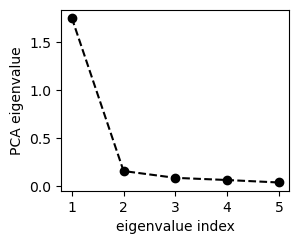

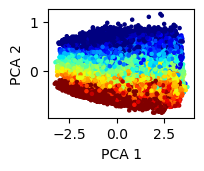

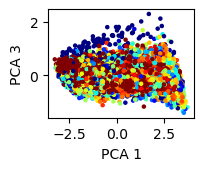

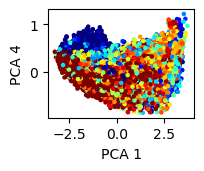

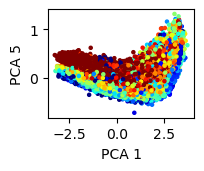

In [10]:
sctm.get_pca() # Get PCA coordinates from cell features
sctm.visual = True
# The feature being colored is the fraction of the cell boundary making cell-cell contact
plot_pca(sctm, nd = 5, colors = sctm.Xf[:, sctm.indfcb[0]]) 

Lets see what typical single-cell trajectories look like in the cell morphology feature PCA space.

In [11]:
%%capture
sctm.get_unique_trajectories() # Assemble trajectories from cell tracking linkages
traj_lengths = np.array([])
for itraj in range(len(sctm.trajectories)): # Iterate over trajectories and get trajectory lengths
    traj_lengths = np.append(traj_lengths, sctm.trajectories[itraj].size)    
indtrajs = np.argsort(traj_lengths) # Just a length-ordered array of trajectory indices

In [15]:
# Make a plot of cell coordinate and single-cell images along a cell trajectory
def show_cell_trajectory(self, cell_traj, x = None, traj = None, nbins = 100): 
    if x is None:
        x = self.Xtraj
    if traj is None:
        traj = self.traj
    plt.figure(figsize = (8, 4))
    prob, xedges1, yedges1 = np.histogram2d(x[:, 0], x[:, 1], bins = nbins, density = True) # Coordinate landscape probability distribution
    xx, yy = np.meshgrid(.5*xedges1[1:] + .5*xedges1[0:-1], .5*yedges1[1:] + .5*yedges1[0:-1]) # Grid coordinates
    xt, inds_traj = sctm.get_Xtraj_celltrajectory(cell_traj, Xtraj = x, traj = traj) # Get coordinates, cell indices along trajectory set
    cell_traj = sctm.traj[inds_traj,-1]
    nt = cell_traj.size
    icell = cell_traj[-1]; iS=1;
    for itt in range(nt):
        clear_output(wait=True)
        plt.clf()
        plt.subplot(1, 2, 1)
        cs = plt.contourf(xx, yy, prob.T, cmap = plt.cm.Greys, extend = 'both')
        cs.cmap.set_over('black')
        plt.axis('off')
        ax = plt.gca()
        for ittt in range(itt-1):
            ax.arrow(xt[ittt, 0], xt[ittt, 1], xt[ittt+1, 0] - xt[ittt, 0], xt[ittt+1, 1] - xt[ittt, 1],
                     head_width = .2, linewidth = 1.0, color = plt.cm.winter(ittt/nt), alpha = 1.0)
        plt.subplot(1, 2, 2)
        sctm.get_cellborder_images(indcells = np.array([cell_traj[itt]]), bordersize = 80)
        imgcell = sctm.cellborder_imgs[0]
        mskcell = sctm.cellborder_msks[0]
        fmskcell = sctm.cellborder_fmsks[0]
        ccborder, csborder = sctm.get_cc_cs_border(mskcell, fmskcell)
        plt.imshow(np.ma.masked_where(fmskcell == 0, imgcell), cmap = plt.cm.seismic, clim = (-5, 5), alpha = 1.0)
        plt.imshow(np.ma.masked_where(fmskcell == 1, imgcell), cmap = plt.cm.gray, clim = (-5, 5), alpha = 0.6)
        nx = imgcell.shape[0]; ny = imgcell.shape[1]
        xxc, yyc = np.meshgrid(np.arange(nx), np.arange(ny), indexing='ij')
        cmskx = np.sum(np.multiply(xxc, mskcell))/np.sum(mskcell)
        cmsky = np.sum(np.multiply(yyc, mskcell))/np.sum(mskcell)
        scatter_x = plt.scatter(cmsky, cmskx, s = 600, color = 'black', marker = 'x', alpha = 0.6)
        plt.axis('off')
        plt.pause(.33)

extracting cellborders from frame 109 image 0


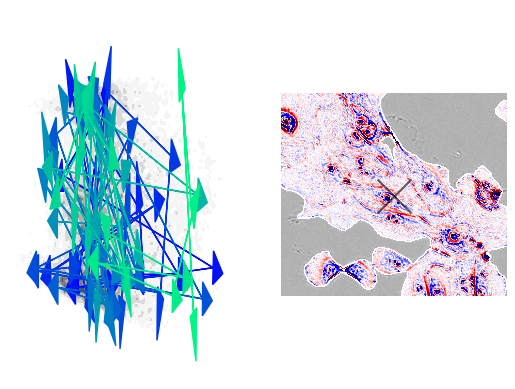

In [16]:
sctm.trajl = 1
sctm.traj = sctm.get_traj_segments(1) # Get trajectory segments, to be consistent with trajectory embeddings
cell_traj = sctm.trajectories[indtrajs[-6]]
show_cell_trajectory(sctm, cell_traj, x = sctm.Xpca[:, 0:2], traj = sctm.traj)

In the single-timepoint morphological feature space, the trajectory appears pretty random. Now let's see what this
trajectory looks like in a morphodynamical trajectory embedding space (trajectory length of 4 or 8 hours)

extracting cellborders from frame 109 image 0


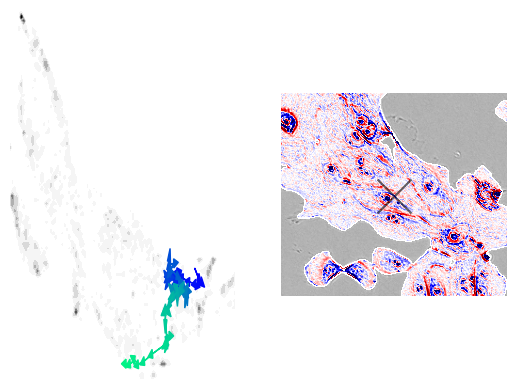

In [17]:
# Concatenates PCA features along trajectories of length "trajl = traj_snip_length", 
# and then embeds morphodynamical feature trajectory into a UMAP of dimension 2 
trajl = 17 # 4 hrs
sctm.get_trajectory_embedding(trajl, embedding_type = 'UMAP', neigen = 2, get_trajectories = False)
show_cell_trajectory(sctm, sctm.trajectories[indtrajs[-6]], x = sctm.Xtraj, traj = sctm.traj)

In the morphodynamical trajectory embedding space, you can begin to see consistent cell state transition pathways even in this single condition and single field-of-view limited dataset. 